# Klasyfikacja chorób na zbiorze ChestMnist

## Przygotowanie środowiska

In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from medmnist import ChestMNIST
from torchvision import transforms
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

## Przygotowanie danych

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
train_ds = ChestMNIST(root='./data', split='train', size=224, transform=transform, download=True)
validation_ds = ChestMNIST(root='./data', split='val', size=224, transform=transform, download=True)
test_ds = ChestMNIST(root='./data', split='test', size=224, transform=transform, download=True)

100%|██████████| 3.89G/3.89G [16:11<00:00, 4.01MB/s] 


In [6]:
CLASS_NAMES = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

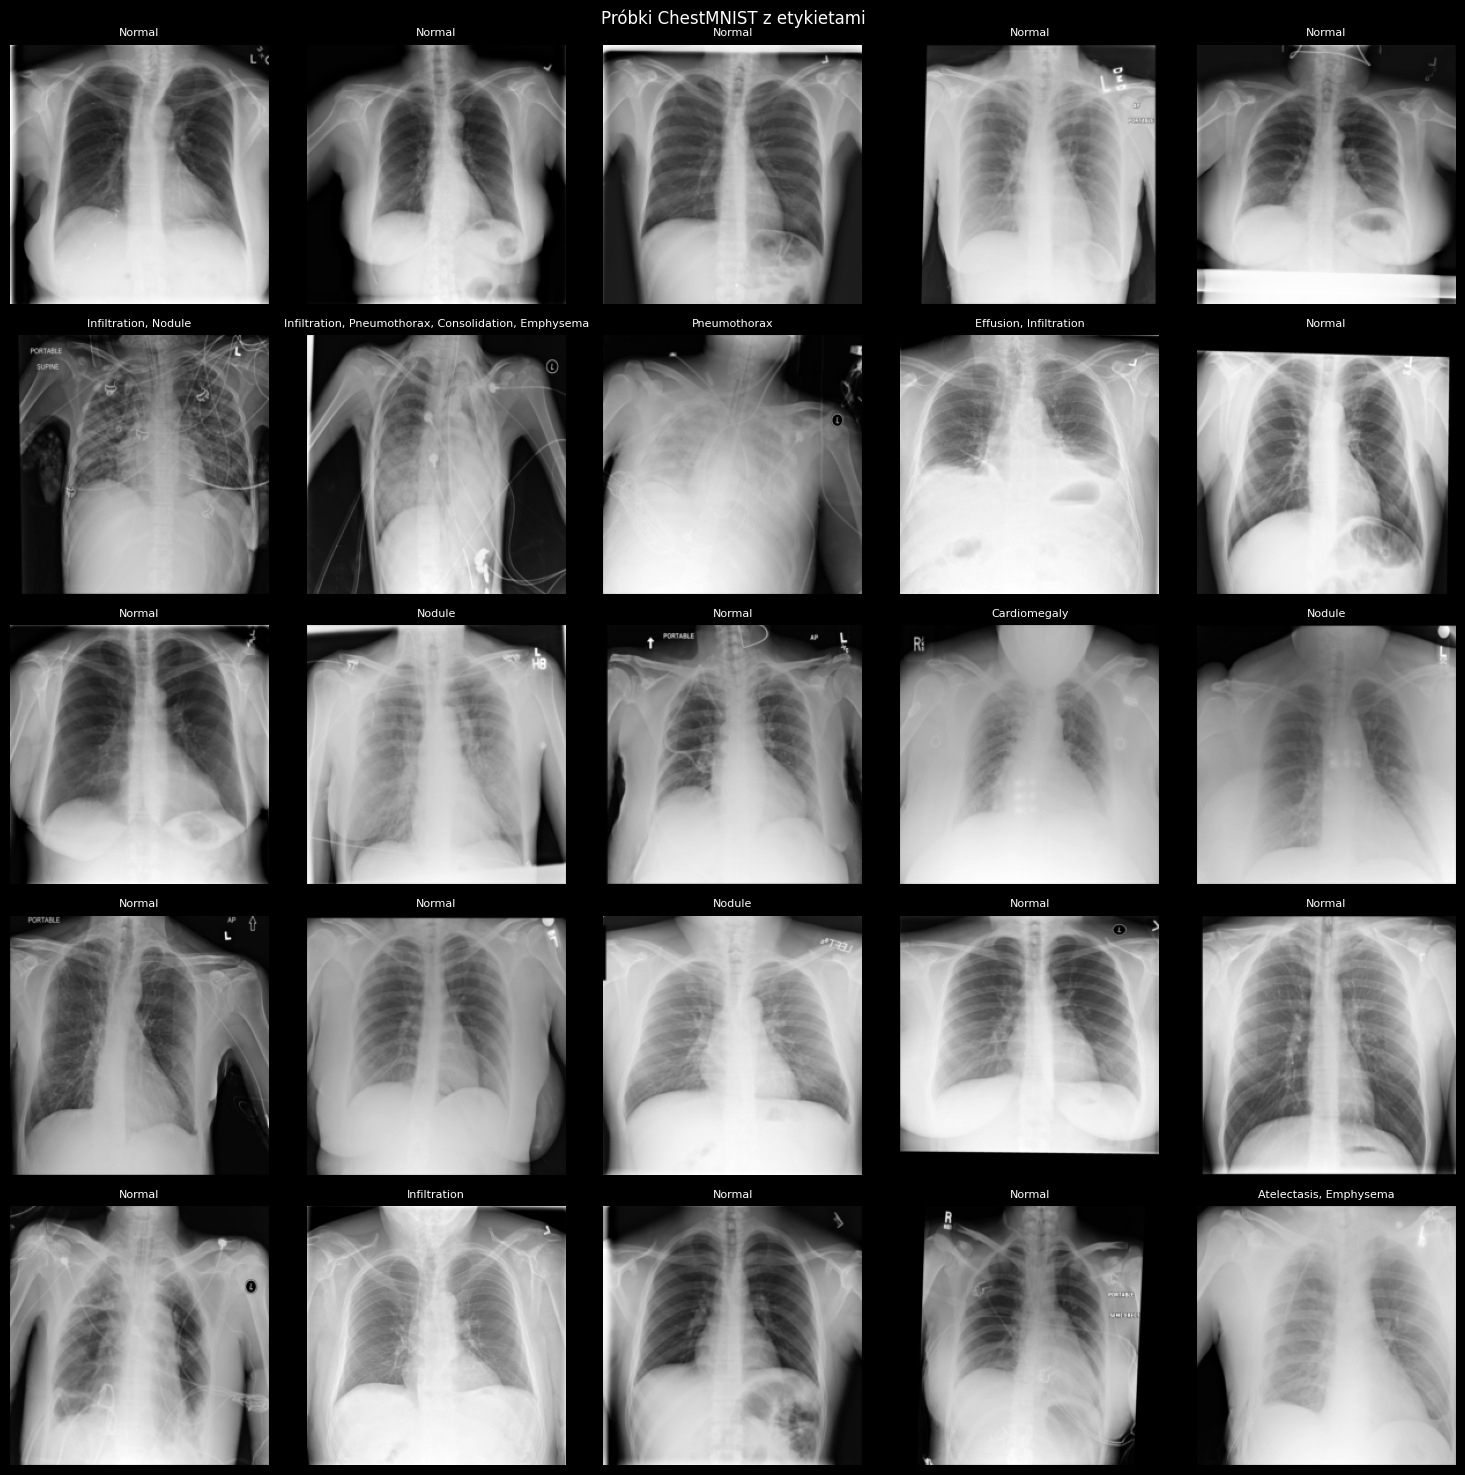

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25):
    img, label = train_ds[i]

    if img.ndim == 3:
        img = img.squeeze(0)

    active_classes = [
        CLASS_NAMES[j] for j, v in enumerate(label) if v == 1
    ]

    title = ", ".join(active_classes) if active_classes else "Normal"

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(title, fontsize=8)
    axes[i].axis("off")

plt.suptitle("Próbki ChestMNIST z etykietami", fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    validation_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

## Trenowanie modelu

### Model konwolucyjnej sieci neuronowej

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.modules.activation.ReLU(inplace=True)
        self.maxpool1 = nn.modules.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.modules.activation.ReLU(inplace=True)
        self.maxpool2 = nn.modules.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.modules.activation.ReLU(inplace=True)
        self.maxpool3 = nn.modules.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.modules.activation.ReLU(inplace=True)
        self.maxpool4 = nn.modules.MaxPool2d(kernel_size=(2, 2))

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(in_features=1 * 1 * 256, out_features=num_classes)
        
                                             
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.gap(x)

        x = torch.flatten(x, 1)
        out = self.fc(x)

        return out

In [10]:
def train_step(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)         

        optimizer.zero_grad()
        outputs = model(inputs)                     
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    epoch_loss = sum(total_loss) / len(total_loss)

    return epoch_loss

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score 

def get_auc(labels, preds):
    auc = 0
    for i in range(labels.shape[1]):
        auc += roc_auc_score(labels[:, i], preds[:, i])
    
    return auc / preds.shape[1]

def get_acc(labels, preds, threshold=0.5):
    acc = 0.0 

    one_zero_preds = (preds > threshold).astype(int)
    for label in range(preds.shape[1]):
        acc += accuracy_score(labels[:, label], one_zero_preds[:, label])

    return acc / preds.shape[1]

In [12]:
import numpy as np

@torch.no_grad()
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = []
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        
        outputs = model(inputs.to(device))

        loss = criterion(outputs, labels)

        preds = torch.sigmoid(outputs)

        total_loss.append(loss.item())
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

    val_loss = np.mean(total_loss)

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    auc = get_auc(all_labels, all_preds)
    acc = get_acc(all_labels, all_preds)

    return val_loss, auc, acc

In [13]:
model = CNN().to(device)

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train_step(model, train_loader, optimizer, criterion, device)
    val_loss, val_auc, val_acc  = validate(model, val_loader, criterion, device)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], " 
        f"train loss: {train_loss:.4f}, "
        f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, val auc: {val_auc:.4f}"
    )

Epoch [1/5], train loss: 0.1823, val loss: 0.1765, val acc: 0.9492, val auc: 0.6180
Epoch [2/5], train loss: 0.1776, val loss: 0.1742, val acc: 0.9492, val auc: 0.6401
Epoch [3/5], train loss: 0.1756, val loss: 0.1736, val acc: 0.9492, val auc: 0.6745
Epoch [4/5], train loss: 0.1727, val loss: 0.1719, val acc: 0.9492, val auc: 0.6877
Epoch [5/5], train loss: 0.1704, val loss: 0.1680, val acc: 0.9491, val auc: 0.7086
